<a href="https://colab.research.google.com/github/AbeNassar/Playground/blob/master/PyStan/0102_Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://mc-stan.org/docs/2_23/stan-users-guide/index.html

In [ ]:
import pystan
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
stan_reg_model = """
    data {
      int<lower=0> N;   // number of data items
      int<lower=0> K;   // number of predictors
      matrix[N, K] x;   // predictor matrix
      vector[N] y;      // outcome vector
    }
    transformed data {
      matrix[N, K] Q_ast;
      matrix[K, K] R_ast;
      matrix[K, K] R_ast_inverse;
      // thin and scale the QR decomposition
      Q_ast = qr_thin_Q(x) * sqrt(N - 1);
      R_ast = qr_thin_R(x) / sqrt(N - 1);
      R_ast_inverse = inverse(R_ast);
    }
    parameters {
      real alpha;           // intercept
      vector[K] theta;      // coefficients on Q_ast
      real<lower=0> sigma;  // error scale
    }
    model {
      y ~ normal(Q_ast * theta + alpha, sigma);  // likelihood
    }
    generated quantities {
      vector[K] beta;
      beta = R_ast_inverse * theta; // coefficients on x
    }"""

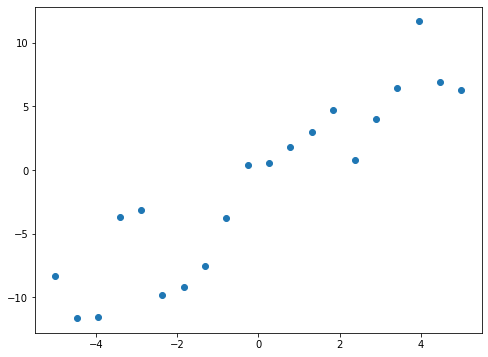

In [ ]:
N = 20
e = 3
b = 2
c = -1

x = np.linspace(-5,5,N)
y = x*b + c + ss.norm(0,e).rvs(N)

plt.figure(1, figsize=[8,6])
plt.scatter(x,y)
plt.show()
plt.close(1)

In [ ]:
stan_regression = pystan.StanModel(model_code=stan_reg_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_87a4579e57506a9c0e30a96f1d521882 NOW.


In [ ]:
reg_dat = {'x': x.reshape(N,1),
           'y': y,
           'N': N,
           'K': 1}

fit = stan_regression.sampling(data=reg_dat, iter=1000, chains=4)

Inference for Stan model: anon_model_87a4579e57506a9c0e30a96f1d521882.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     -1.09    0.02   0.72  -2.52  -1.56   -1.1  -0.61   0.36   1509    1.0
theta[1]   6.28    0.02   0.74   4.82   5.84   6.29   6.74   7.79   1595    1.0
sigma      3.16    0.02   0.58   2.28   2.74   3.08   3.48   4.54   1415    1.0
beta[1]    2.02  6.0e-3   0.24   1.55   1.88   2.02   2.16    2.5   1595    1.0
lp__     -31.04    0.04   1.36 -34.57 -31.69 -30.69 -30.04 -29.52    934    1.0

Samples were drawn using NUTS at Fri Apr 23 21:59:41 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


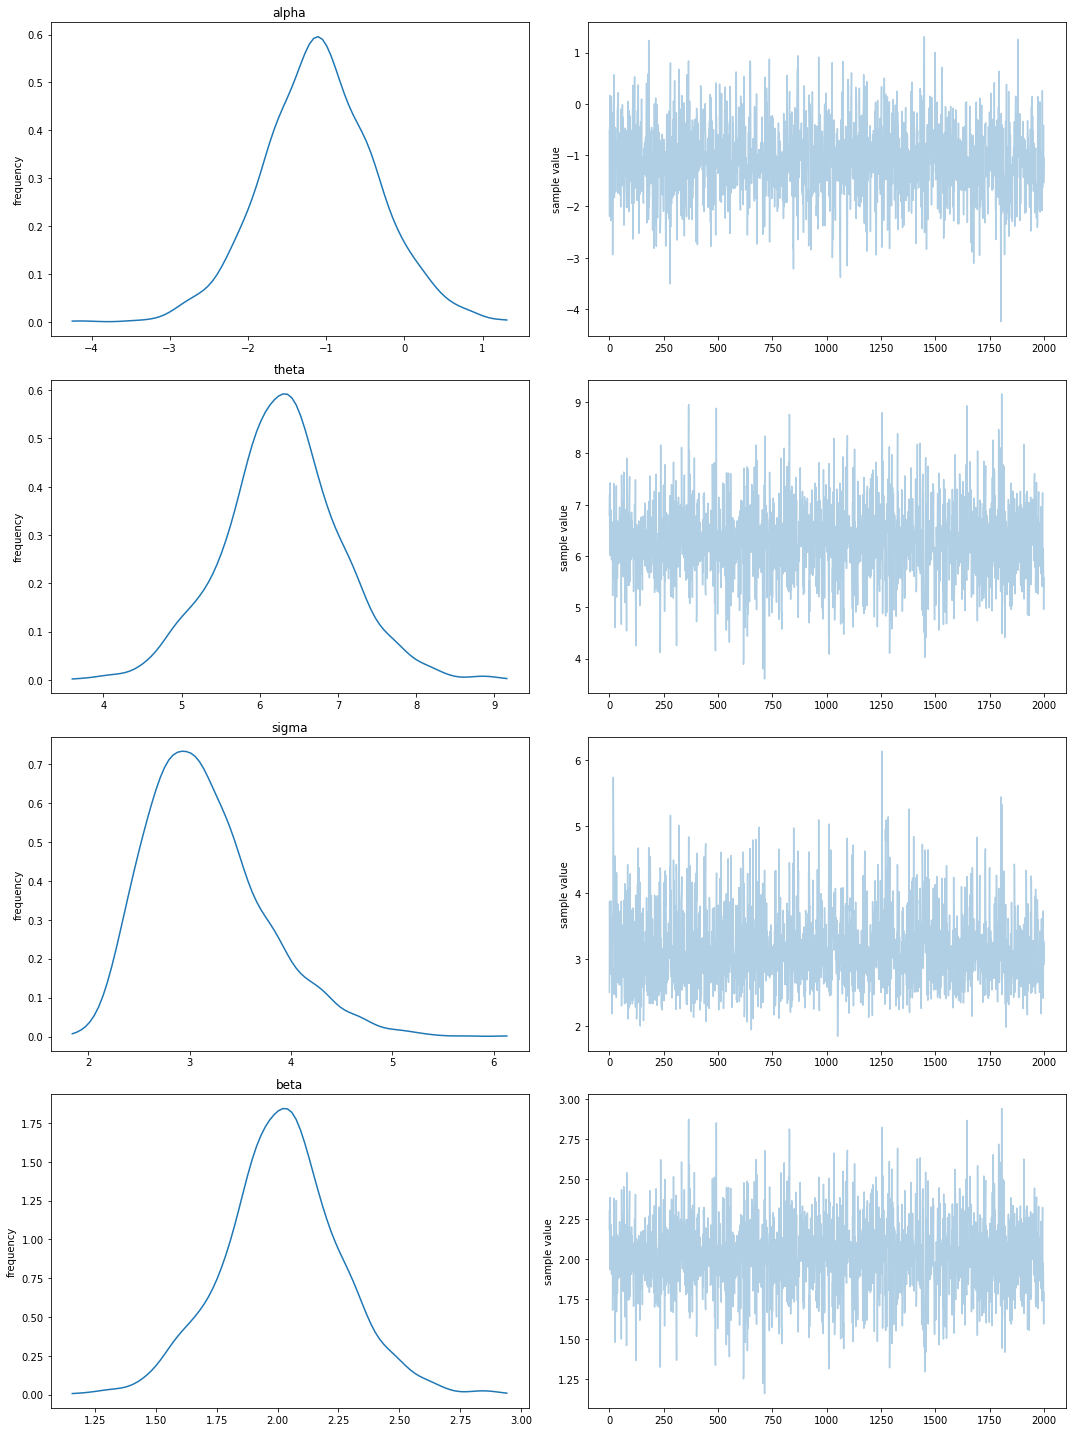

In [ ]:
print(fit.stansummary())

plt.rcParams['figure.figsize'] = 15, 20
fit.plot().tight_layout()

In [ ]:
alpha, theta, sigma, beta, _ = fit.get_posterior_mean().mean(axis=1)

In [ ]:
y_hat = alpha + beta*x

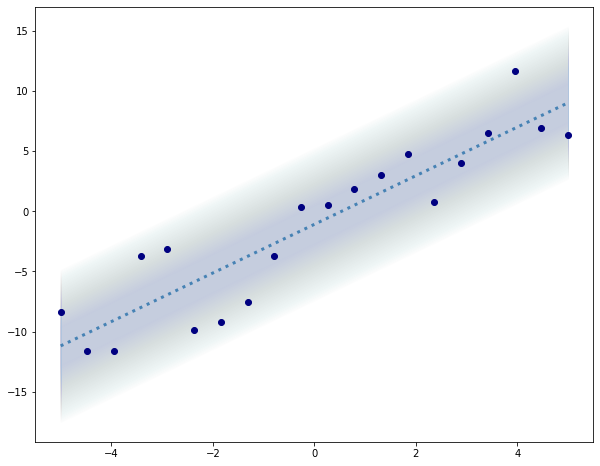

In [ ]:
plt.figure(1, figsize=[10,8])

# For a gradient effect on confidence intervals
G = 50
for i in np.linspace(.5,2,G):
    plt.fill_between(x, 
                     y1=y_hat - i*sigma, 
                     y2=y_hat + i*sigma,
                     alpha=.75/G, 
                     color="lightsteelblue")
plt.plot(x, y_hat, color="steelblue", ls=":", lw=3)
plt.scatter(x, y, color="navy")
plt.show()
plt.close(1)

In [ ]:
import pickle

In [ ]:
stan_loc = "drive/MyDrive/Colab Notebooks/PyStan/"

linear_regression = pystan.StanModel(model_code=stan_reg_model)
with open(stan_loc + "compiled_models/linear_regression.pkl", "wb") as s:
  pickle.dump(linear_regression, s)

del linear_regression

In [ ]:
class BayesianLinearRegression:
  """Bayesian linear regression model written in Stan.
  
  Attributes
  ------------
  compiled_model_location (str)
    location of the compiled model. Default points to the location in my google 
    drive:
      drive/MyDrive/Colab Notebooks/PyStan/compiled_models/linear_regression.pkl
  
  compiled_model (stan model)
    compled Stan model
  
  stan_code_location (str)
    location of stan code. Default points to the location in my google 
    drive:
      drive/MyDrive/Colab Notebooks/PyStan/compiled_models/linear_regression.pkl

    

  """

  def __init__(self, compiled_model_location=None):
    """Initialize the class"""
    if compiled_model_location is None:
      self.compiled_model_location = "drive/MyDrive/Colab Notebooks/PyStan/compiled_models/linear_regression.pkl"
    else:
      self.compiled_model_location = compiled_model_location
    self.compiled_model = pickle.load(open(self.compiled_model_location, 'rb')) 

  def fit(self, X, y, n_chains=4, n_iter=1000):
    """Fit data to the model."""
    self.N, self.K = X.shape
    reg_dat = {'x': X,
              'y': y,
              'N': self.N,
              'K': self.K}

    self.fitted_model = self.compiled_model.sampling(data=reg_dat, 
                                                     iter=n_iter, 
                                                     chains=n_chains)
    return self.fitted_model

  def summary(self):
    """Print summary of the fit."""
    print(self.fitted_model.stansummary())

  def plot_parameter_distribution(self):
    """Plot distribution of the paramters."""
    fit.plot().tight_layout()


In [ ]:
lm = BayesianLinearRegression()

In [ ]:
lm.fit(x.reshape(N,1), y)

Inference for Stan model: anon_model_87a4579e57506a9c0e30a96f1d521882.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     -1.11    0.02   0.72   -2.5  -1.57   -1.1  -0.64   0.27   1486    1.0
theta[1]   6.29    0.02   0.74   4.79   5.82    6.3   6.76   7.78   1470    1.0
sigma      3.18    0.02    0.6   2.26   2.77   3.08   3.52   4.52   1162    1.0
beta[1]    2.02  6.2e-3   0.24   1.54   1.87   2.02   2.17    2.5   1470    1.0
lp__     -31.08    0.05   1.35 -34.57 -31.71 -30.78 -30.09 -29.52    883    1.0

Samples were drawn using NUTS at Fri Apr 23 22:25:11 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [ ]:
lm.summary()

Inference for Stan model: anon_model_87a4579e57506a9c0e30a96f1d521882.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     -1.11    0.02   0.72   -2.5  -1.57   -1.1  -0.64   0.27   1486    1.0
theta[1]   6.29    0.02   0.74   4.79   5.82    6.3   6.76   7.78   1470    1.0
sigma      3.18    0.02    0.6   2.26   2.77   3.08   3.52   4.52   1162    1.0
beta[1]    2.02  6.2e-3   0.24   1.54   1.87   2.02   2.17    2.5   1470    1.0
lp__     -31.08    0.05   1.35 -34.57 -31.71 -30.78 -30.09 -29.52    883    1.0

Samples were drawn using NUTS at Fri Apr 23 22:25:11 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
fig = fit.__sizeof__

In [ ]:
fig.show()